# Metabolon pilot Human Metabolite Disease Network

In [101]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from scipy import stats
from statsmodels.stats.multitest import multipletests
import networkx as nx
import requests

## Processing datasets

In [157]:

class MetabolonDataset:
    '''
    Class to load and QC metabolon data
    '''
    def __init__(self, file_path, id, node_name, first_row_index, first_col_index, identifiers_row, md_sampname, md_group, md_filter):
        self.file_path = file_path
        self.raw_data = None
        self.compound_mappers = None
        self.processed_data = None
        self.metadata = None
        self.id = id
        self.node_name = node_name
        self.first_row_index = first_row_index
        self.first_col_index = first_col_index
        self.identifiers_row = identifiers_row
        self.md_sampname = md_sampname
        self.md_group = md_group
        self.md_filter = md_filter
        self.DA_metabolites = None

        self.read_data(file_path)
        self.preprocess_data()
        self.da_testing()
        
    def read_data(self, file_path):
        """
        Read in the metabolon data
        """
        # read in the data
        data = pd.read_excel(file_path + '/peaktable.xlsx', header=None)
        self.raw_data = data

        self.compound_mappers = data.iloc[self.first_row_index:, 0:self.first_col_index+1]
        # self.compound_mappers.columns = data.iloc[self.first_row_index-1, 0:self.first_col_index+1]
        # self.compound_mappers.columns = self.compound_mappers.columns.str.replace('.*HMDB_ID*', 'HMDB')

        metadata = pd.read_csv(file_path + '/s_' + self.id + '.txt', sep = '\t')

        self.metadata = metadata
        self.metadata[self.md_sampname] = self.metadata[self.md_sampname].astype(str)
        print(metadata[[self.md_sampname, self.md_group]].head())

        return data, metadata

    def preprocess_data(self):
        data_filt = self.raw_data.copy()
        data_filt.index = data_filt.iloc[:, 0]
        data_filt.columns = data_filt.iloc[self.identifiers_row, :].astype(str)
        data_filt = data_filt.iloc[self.first_row_index:, self.first_col_index:]

        # ensure all data is numeric
        data_filt = data_filt.apply(pd.to_numeric, errors='coerce')

        # Transpose
        data_filt = data_filt.T

        # Missingness checks 
        # replace empty strings with NaN
        data_filt = data_filt.replace(['', ' '], np.nan)
        # Delete colums and rows where all values are missing
        data_filt = data_filt.dropna(axis=0, how='all')
        data_filt = data_filt.dropna(axis=1, how='all')

        data_filt = data_filt.dropna(axis=1, thresh=0.3*data_filt.shape[0])
        missing_pct = data_filt.isnull().sum().sum() / (data_filt.shape[0] * data_filt.shape[1]) * 100
        print(f"Missingness: {missing_pct:.2f}%")

        # impute missing values
        imputer = KNNImputer(n_neighbors=2, weights="uniform").set_output(transform="pandas")
        data_imputed = imputer.fit_transform(data_filt)

        # log transformation
        data_imputed = np.log(data_imputed + 1)

        # standardize
        scaler = StandardScaler().set_output(transform="pandas")
        data_scaled = scaler.fit_transform(data_imputed)

        # add metadata column
        md_dict = dict(zip(self.metadata[self.md_sampname], self.metadata[self.md_group]))
        data_scaled['Group'] = data_scaled.index.map(md_dict)


        # filter on metadata
        # TODO check whether to rescale after filtering
        data_scaled = data_scaled[data_scaled['Group'].isin(self.md_filter)]

        # rescale data
        data_rescaled = data_scaled.iloc[:, :-1].apply(lambda x: (x - x.mean()) / x.std())
        data_rescaled['Group'] = data_scaled['Group']

        self.processed_data = data_rescaled

        return data_rescaled
    
    def plot_qc(self):
        
        # PCA biplot
        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(self.processed_data.iloc[:, :-1])

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        sns.scatterplot(
            x=pca_result[:, 0], y=pca_result[:, 1],
            hue="Group",
            data=self.processed_data,
            alpha=0.7,
            ax=ax1
        )

        # normality every nth feature
        normaliser = (self.processed_data.shape[1] - 1) / 20
        sns.boxplot(data=self.processed_data.iloc[:, ::50], ax=ax2)
        plt.show()

    def da_testing(self):

        # t-test for two groups
        groups = self.processed_data['Group'].unique()
        stat, pvals = stats.ttest_ind(self.processed_data[self.processed_data['Group'] == groups[0]].iloc[:, :-1],
                        self.processed_data[self.processed_data['Group'] == groups[1]].iloc[:, :-1],
                        alternative='two-sided')
        pval_df = pd.DataFrame(pvals, index=self.processed_data.columns[:-1], columns=['P-value'])

        # fdr correction 
        pval_df['FDR_P-value'] = multipletests(pvals, method='fdr_bh')[1]

        # return significant metabolites
        self.DA_metabolites = pval_df[pval_df['FDR_P-value'] < 0.05].index.tolist()
        print(f"Number of differentially abundant metabolites: {len(self.DA_metabolites)}") 

        # generate tuples for nx links
        self.connection = [(self.node_name, met) for met in self.DA_metabolites]

    def get_class_info(self, hmdbs=None):

        if hmdbs == None:
            hmdbs = self.compound_mappers['HMDB'].tolist()
        hmdb_ids = ['hmdb:' + str(hmdb) for hmdb in hmdbs if not pd.isna(hmdb)]
        print(hmdb_ids)
        api_url = "https://rampdb.nih.gov/api/chemical-classes"
        request_body = {
        "metabolites": hmdb_ids
        }
        response = requests.post(api_url, json=request_body, verify=False)
        resp_json = response.json()['data']
        resp_df = pd.DataFrame.from_dict(resp_json)
        return resp_df
    



In [196]:
    def get_class_info(hmdbs):
        hmdb_ids = dict(zip(hmdbs, ['hmdb:' + str(hmdb) for hmdb in hmdbs]))
        hmdb_ids_filt = {k: v for k, v in hmdb_ids.items() if not pd.isna(k)}
        print(hmdb_ids_filt)
        api_url = "https://rampdb.nih.gov/api/chemical-classes"
        request_body = {
        "metabolites": list(hmdb_ids_filt.values())
        }
        response = requests.post(api_url, json=request_body, verify=False)
        resp_json = response.json()['data']
        resp_df = pd.DataFrame.from_dict(resp_json)
        resp_df['Original_HMDB'] = resp_df.sourceId.map({v: k for k, v in hmdb_ids_filt.items()})
        return resp_df

In [149]:
sct_data = MetabolonDataset(
    file_path='MTBLS220',
    id='MTBLS220',
    node_name='Stem cell transplant (donor/recipient)',
    first_row_index=3,
    first_col_index=6,
    identifiers_row=0,
    md_sampname='Sample Name',
    md_group='Factor Value[Group class]',
    md_filter=['Donor', 'Recipient']

)

  Sample Name Factor Value[Group class]
0  HSLO-00137                 Recipient
1  HSLO-00143                 Recipient
2  HSLO-00128                 Recipient
3  HSLO-00122                 Recipient
4  HSLO-00098                 Recipient
Missingness: 7.44%
Number of differentially abundant metabolites: 3


In [150]:
sct_data.compound_mappers

,0,1,2,3,4,5,6
3,(N(1) + N(8))-acetylspermidine,Method 1,NaN,NaN,NaN,NaN,NaN
4,"1,2,3-benzenetriol sulfate (2)",Method 3,NaN,NaN,NaN,NaN,NaN
5,"1,2-dilinoleoyl-GPC (18:2/18:2)",Method 2,998-06-1,5288075,4450312,NaN,HMDB08138
6,"1,2-dilinoleoyl-GPE (18:2/18:2)*",Method 2,NaN,9546812,7825762,NaN,HMDB09093
7,"1,2-dipalmitoyl-GPC (16:0/16:0)",Method 2,63-89-8,452110,398235,D03585,HMDB00564
...,...,...,...,...,...,...,...
839,xanthine,Method 4,69-89-6,1188,1151,C00385,HMDB00292
840,xanthosine,Method 3,146-80-5,64959,58484,C01762,HMDB00299
841,xanthurenate,Method 3,59-007,5699,5497,C02470,HMDB00881
842,ximenoylcarnitine (C26:1)*,Method 2,NaN,NaN,NaN,NaN,NaN


In [152]:
sct_data.get_class_info(hmdbs=sct_data.compound_mappers.loc[:, 6].tolist())

['hmdb:HMDB08138', 'hmdb:HMDB09093', 'hmdb:HMDB00564', 'hmdb:HMDB02123', 'hmdb:HMDB01857', 'hmdb:HMDB02712', 'hmdb:HMDB11103', 'hmdb:HMDB11220', 'hmdb:HMDB11352', 'hmdb:HMDB11211', 'hmdb:HMDB11343', 'hmdb:HMDB11342', 'hmdb:HMDB11207', 'hmdb:HMDB11206', 'hmdb:HMDB10407', 'hmdb:HMDB05779', 'hmdb:HMDB11376', 'hmdb:HMDB11375', 'hmdb:HMDB10395', 'hmdb:HMDB11517', 'hmdb:HMDB61690', 'hmdb:HMDB11549', 'hmdb:HMDB11587', 'hmdb:HMDB10405', 'hmdb:HMDB10388', 'hmdb:HMDB11569', 'hmdb:HMDB08147', 'hmdb:HMDB08141', 'hmdb:HMDB07856', 'hmdb:HMDB10386', 'hmdb:HMDB11507', 'hmdb:HMDB00001', 'hmdb:HMDB02820', 'hmdb:HMDB00699', 'hmdb:HMDB03099', 'hmdb:HMDB10738', 'hmdb:HMDB07883', 'hmdb:HMDB07869', 'hmdb:HMDB11561', 'hmdb:HMDB08123', 'hmdb:HMDB05349', 'hmdb:HMDB02815', 'hmdb:HMDB11506', 'hmdb:HMDB11567', 'hmdb:HMDB08008', 'hmdb:HMDB08006', 'hmdb:HMDB10383', 'hmdb:HMDB11565', 'hmdb:HMDB07975', 'hmdb:HMDB07982', 'hmdb:HMDB05323', 'hmdb:HMDB09789', 'hmdb:HMDB07991', 'hmdb:HMDB05324', 'hmdb:HMDB07974', 'hmdb:HMD

c:\Users\cw2019\.conda\envs\py10\lib\site-packages\urllib3\connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host 'rampdb.nih.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


,sourceId,common_names,class_level_name,class_name,source,directIdClassHits
0,hmdb:HMDB00001,1-Methylhistidine,ClassyFire_class,Carboxylic acids and derivatives,hmdb,2
1,hmdb:HMDB00001,1-Methylhistidine,ClassyFire_sub_class,"Amino acids, peptides, and analogues",hmdb,2
2,hmdb:HMDB00001,1-Methylhistidine,ClassyFire_super_class,Organic acids and derivatives,hmdb,2
3,hmdb:HMDB00479,1-Methylhistidine,ClassyFire_class,Carboxylic acids and derivatives,hmdb,2
4,hmdb:HMDB00479,1-Methylhistidine,ClassyFire_sub_class,"Amino acids, peptides, and analogues",hmdb,2
...,...,...,...,...,...,...
2583,hmdb:HMDB06547,"C18:4n-3,6,9,12; Stearidonic acid",ClassyFire_sub_class,Lineolic acids and derivatives,hmdb,2
2584,hmdb:HMDB06547,"C18:4n-3,6,9,12; Stearidonic acid",ClassyFire_super_class,Lipids and lipid-like molecules,hmdb,2
2585,hmdb:HMDB06547,"C18:4n-3,6,9,12; Stearidonic acid",LipidMaps_category,Fatty Acyls [FA],lipidmaps,2
2586,hmdb:HMDB06547,"C18:4n-3,6,9,12; Stearidonic acid",LipidMaps_main_class,Fatty Acids and Conjugates [FA01],lipidmaps,2


In [ ]:
sns.FacetGrid

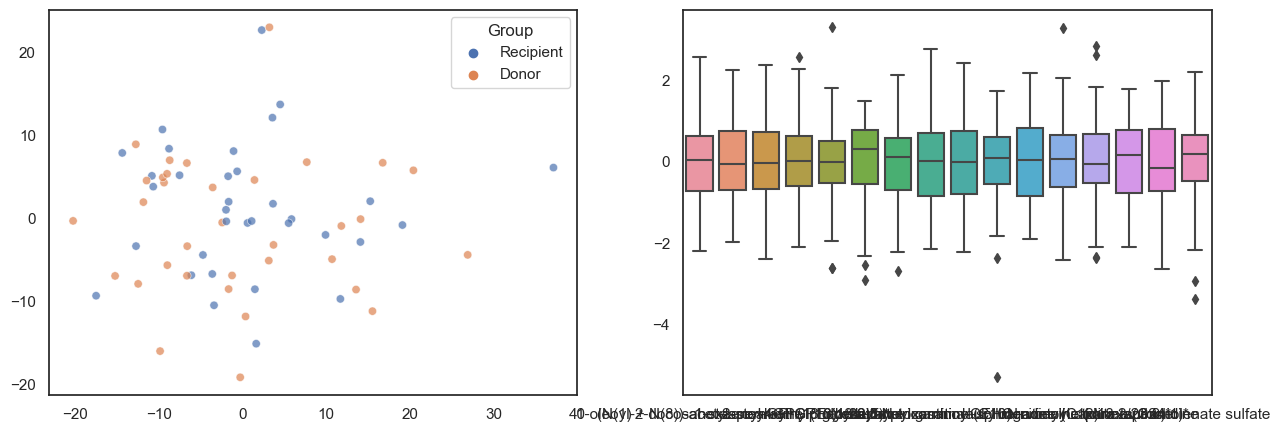

In [94]:
sct_data.plot_qc()

In [95]:
sct_data.processed_data


,(N(1) + N(8))-acetylspermidine,"1,2,3-benzenetriol sulfate (2)","1,2-dilinoleoyl-GPC (18:2/18:2)","1,2-dilinoleoyl-GPE (18:2/18:2)*","1,2-dipalmitoyl-GPC (16:0/16:0)","1,3,7-trimethylurate","1,3-dimethylurate","1,5-anhydroglucitol (1,5-AG)","1,7-dimethylurate",1-(1-enyl-oleoyl)-GPE (P-18:1)*,...,valine,vanillactate,vanillic alcohol sulfate,vanillylmandelate (VMA),xanthine,xanthosine,xanthurenate,ximenoylcarnitine (C26:1)*,xylose,Group
nan,,,,,,,,,,,,,,,,,,,,,
HSLO-00093,-0.433557,-0.153248,-1.202158,-0.147709,-0.401507,0.041772,0.753439,-0.230102,0.662884,-0.510490,...,-1.464867,-0.846854,1.982174,0.597304,-0.303984,-0.843794,-0.251650,-0.531219,0.214551,Recipient
HSLO-00094,-1.918461,0.858024,-0.031133,0.875059,0.230404,-0.019055,-0.203957,0.752084,-0.548585,-0.198370,...,-0.853463,-0.481861,-0.218852,-0.454010,-0.705055,-0.535677,-0.335466,-1.616311,0.637303,Donor
HSLO-00095,0.015215,-0.395620,-0.281928,-0.661630,-1.565697,0.524787,-0.291765,1.042714,-0.057406,0.448932,...,-0.675982,-1.586320,0.387816,-0.597100,-0.070894,2.059529,-2.161896,-0.205591,-1.160372,Donor
HSLO-00096,-0.276556,0.280506,0.999900,0.479379,0.187632,0.583575,0.299116,-0.107483,0.037880,-1.001468,...,0.269373,-0.277058,0.298060,0.803595,-0.524171,-0.848715,-0.079435,0.244885,-0.163236,Recipient
HSLO-00097,0.636618,0.272906,1.174011,0.286109,-0.535906,-0.311076,-1.933500,0.621066,-3.340757,0.598010,...,1.233705,-0.616577,0.156252,-0.662173,-0.916006,0.053253,0.583794,-0.704614,-0.451021,Donor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HSLO-00167,1.330358,0.652439,1.205863,-0.587696,0.420624,0.296819,0.451237,0.392571,1.291031,0.408773,...,-2.400157,2.207073,1.313266,1.453202,-2.323372,-0.609062,-0.281778,0.853133,0.175787,Recipient
HSLO-00168,0.031284,-0.008336,0.953786,2.653622,0.240247,0.427996,0.550564,-0.009118,1.105002,0.710834,...,-0.673217,1.495664,-0.512047,1.055273,-0.268193,1.271565,0.937040,0.148789,0.718250,Donor
HSLO-00169,-1.211241,-0.977578,-1.003803,-0.153961,0.327882,-0.702221,-0.326615,0.631100,0.033036,-1.934926,...,0.906044,0.028784,1.796890,-0.345870,0.439441,-0.722739,0.608908,-0.508919,0.128224,Donor


In [158]:
pkm2_data = MetabolonDataset(
    file_path = 'MTBLS533',
    id = 'MTBLS533',
    node_name = 'PKM2 knockout cell line (GT)',
    first_row_index = 3,
    first_col_index = 6,
    identifiers_row = 0,
    md_sampname = 'Sample Name',
    md_group = 'Factor Value[Genotype]',
    md_filter = ['M2', 'CARM1 KO']
)

  Sample Name Factor Value[Genotype]
0  UWIM-00278                     WT
1  UWIM-00279                     WT
2  UWIM-00280                     WT
3  UWIM-00281                     WT
4  UWIM-00282                PKM2 KO
Missingness: 7.79%
Number of differentially abundant metabolites: 539


c:\Users\cw2019\.conda\envs\py10\lib\site-packages\scipy\stats\_axis_nan_policy.py:551: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, axis=axis, **kwds)


In [159]:
pkm2_data.compound_mappers

,0,1,2,3,4,5,6
3,BIOCHEMICAL,METHOD,CAS,PUBCHEM,KEGG,Group HMDB,NaN
4,(N(1) + N(8))-acetylspermidine,Method 1,NaN,NaN,NaN,NaN,9193641
5,1-(1-enyl-oleoyl)-GPE (P-18:1)*,Method 2,NaN,NaN,NaN,NaN,1038937
6,1-(1-enyl-palmitoyl)-2-arachidonoyl-GPC (P-16:...,Method 2,NaN,NaN,NaN,HMDB11220,NaN
7,1-(1-enyl-palmitoyl)-2-arachidonoyl-GPE (P-16:...,Method 2,NaN,NaN,NaN,HMDB11352,9803795
...,...,...,...,...,...,...,...
637,xanthine,Method 3,69-89-6,1188,C00385,HMDB00292,1435840
638,xanthosine,Method 3,146-80-5,64959,C01762,HMDB00299,131062
639,xanthosine 5'-monophosphate (xmp),Method 3,25899-70-1,73323,C00655,HMDB01554,NaN
640,ximenoylcarnitine (C26:1)*,Method 2,NaN,NaN,NaN,NaN,4426485


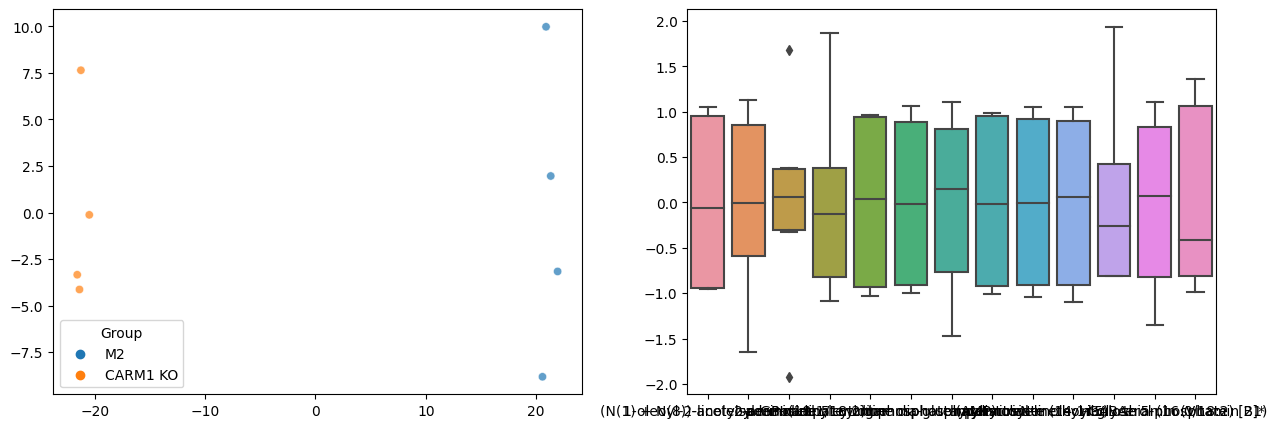

In [7]:
pkm2_data.plot_qc()

In [160]:
erbc_data = MetabolonDataset(
    file_path = 'MTBLS3342', 
    id = 'MTBLS3342', 
    node_name = ' ER+ BC (treatment response)', 
    first_row_index = 5, 
    first_col_index = 6, 
    identifiers_row=0,
    md_sampname='Source Name',
    md_group = 'Factor Value[IACS Response]',
    md_filter=['resistant', 'responder'])

  Source Name Factor Value[IACS Response]
0  4047077212                   responder
1  4047077224                   resistant
2  4047078340                   resistant
3  4047078342                   resistant
4  4047078344                   resistant
Missingness: 5.26%
Number of differentially abundant metabolites: 596


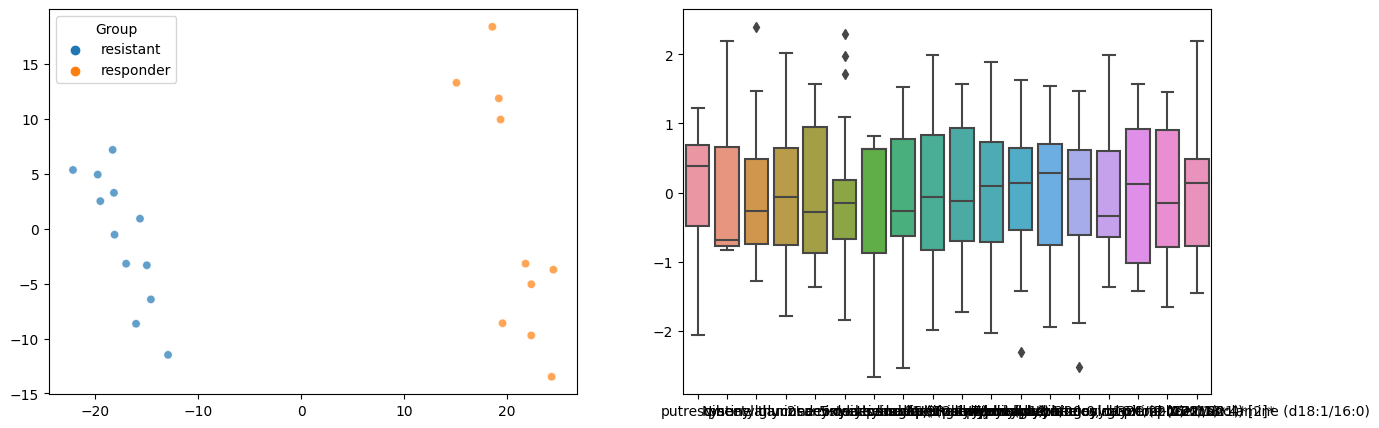

In [23]:
erbc_data.plot_qc()

In [161]:
erbc_data.compound_mappers

,0,1,2,3,4,5,6
5,putrescine,Method 1,1045,110-60-1,C00134,HMDB0001414,35212747
6,spermidine,Method 1,1102,124-20-9,C00315,HMDB0001257,105734180
7,1-methylnicotinamide,Method 1,457,1005-24-9,C02918,HMDB0000699,36008729
8,5-hydroxyindoleacetate,Method 3,1826,54-16-0,C05635,HMDB0000763,
9,"cytidine 2',3'-cyclic monophosphate",Method 3,23421172,15718-51-1,C02354,HMDB0011691,190248
...,...,...,...,...,...,...,...
912,X-25984,Method 3,NaN,NaN,NaN,NaN,438340
913,X-26035,Method 1,NaN,NaN,NaN,NaN,4876613
914,X-26106,Method 2,NaN,NaN,NaN,NaN,569040
915,X-26107,Method 2,NaN,NaN,NaN,NaN,1137039


In [162]:

pmh_data = MetabolonDataset(
    file_path = 'MTBLS136', 
    id = 'MTBLS136', 
    node_name = 'Post-menopausal hormone use', 
    first_row_index=4, 
    first_col_index=9, 
    identifiers_row=1,
    md_sampname='Sample Name',
    md_group='Factor Value[CurrentPMH]',
    md_filter=['Nonuser', 'E-only']
    )


  Sample Name Factor Value[CurrentPMH]
0   063459_01                  Nonuser
1   081531_03                   E-only
2  022817_136                      NaN
3   079243_03                  Nonuser
4   034993_02                   E-only
Missingness: 10.17%
Number of differentially abundant metabolites: 612


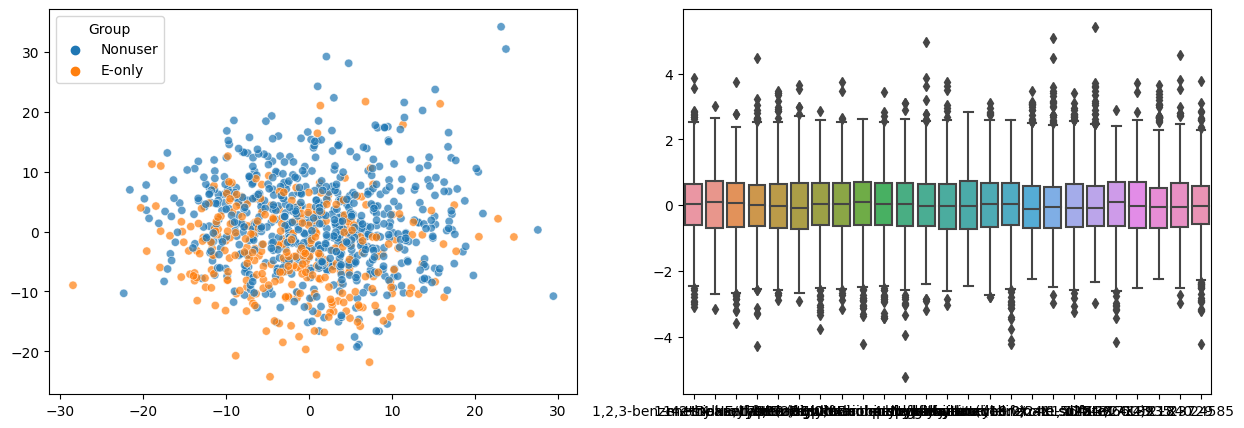

In [10]:
pmh_data.plot_qc()

In [163]:
pmh_data.compound_mappers

,0,1,2,3,4,5,6,7,8,9
4,(15:0)-anacardic acid,Method 3,16611-84-0,167551,146579,C10759,NaN,C10759,NaN,NaN
5,(15:2)-anacardic acid,Method 3,11034-77-8,11824131,9998782,NaN,HMDB33896,NaN,HMDB33896,NaN
6,"1,2,3-benzenetriol sulfate (1)",Method 3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,"1,2,3-benzenetriol sulfate (2)",Method 3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,95695
8,"1,2-dilinoleoyl-GPC (18:2/18:2)",Method 2,998-06-1,5288075,4450312,NaN,HMDB08138,NaN,HMDB08138,311381856
...,...,...,...,...,...,...,...,...,...,...
1384,X - 24932,Method 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,536932
1385,X - 24947,Method 3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1386,X - 24948,Method 3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,534375
1387,X - 24949,Method 3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,84211


In [164]:
preterm_data = MetabolonDataset(
    file_path = 'MTBLS702',
    id = 'MTBLS702',
    node_name = 'Preterm birth (race)',
    first_row_index=2,
    first_col_index=6,
    identifiers_row=1,
    md_sampname='Sample Name',
    md_group='Factor Value[Race]',
    md_filter=['Black', 'White']
    )


  Sample Name Factor Value[Race]
0  UNPA-02736              Black
1  UNPA-02740              Black
2  UNPA-02745              Black
3  UNPA-02749              Black
4  UNPA-02750              Black
Missingness: 22.13%
Number of differentially abundant metabolites: 22


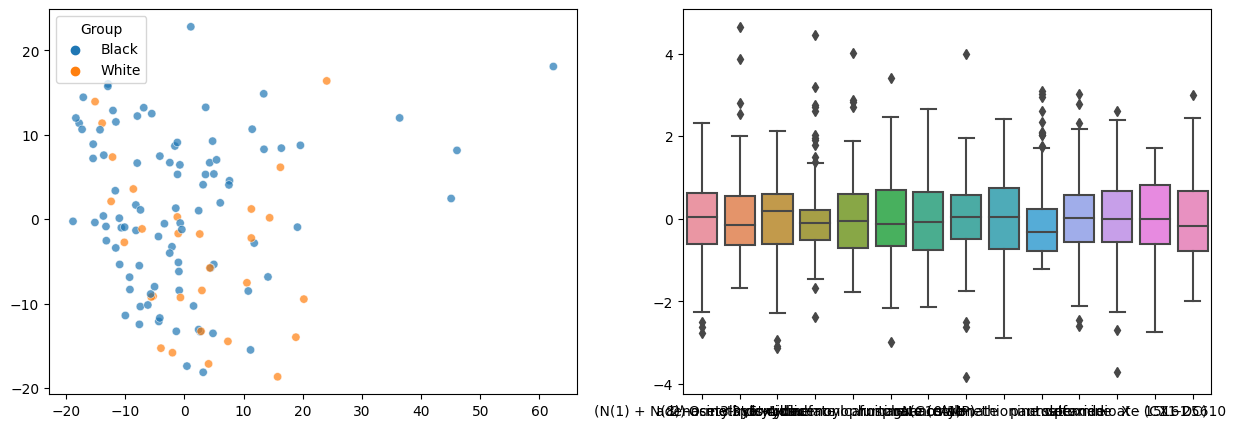

In [12]:
preterm_data.plot_qc()

In [165]:

azmcn_data = MetabolonDataset(
    file_path = 'MTBLS406', 
    id = 'MTBLS406', 
    node_name = 'Azythromycin treatment (gender)', 
    first_row_index = 3, 
    first_col_index = 6, 
    identifiers_row=1,
    md_sampname='Source Name',
    md_group = 'Factor Value[Gender]',
    md_filter=['Male', 'Female']
    )

      Source Name Factor Value[Gender]
0  BG111_24_02_14                 Male
1  ME114_24_02_14               Female
2  GD112_25_02_14                 Male
3  BG111_10_03_14                 Male
4  ME114_10_03_14               Female
Missingness: 8.37%
Number of differentially abundant metabolites: 213


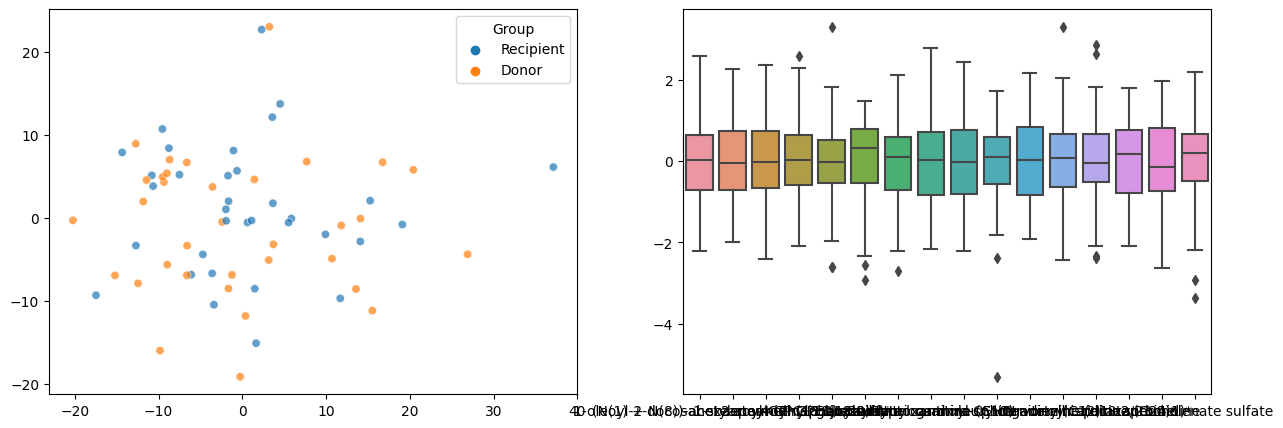

In [14]:
sct_data.plot_qc()

In [5]:
# all_data = MetabolonDataset(
#     file_path = 'MTBLS2394', 
#     id = 'MTBLS2394', 
#     node_name = 'Acute lymphoblastic leukemia', 
#     first_row_index = 2, 
#     first_col_index = 7, 
#     identifiers_row=1,
#     md_sampname='Source Name',
#     md_group = 'Factor Value[Time Point]',
#     md_filter=['inital time point', 'post time point']
#     )

     Source Name Factor Value[Time Point]
0            P01       initial time point
1            P02       initial time point
2            P04       initial time point
3            P05       initial time point
4            P06       initial time point
..           ...                      ...
103  unassigned4                      NaN
104  unassigned5                      NaN
105  unassigned6                      NaN
106  unassigned7                      NaN
107  unassigned8                      NaN

[108 rows x 2 columns]


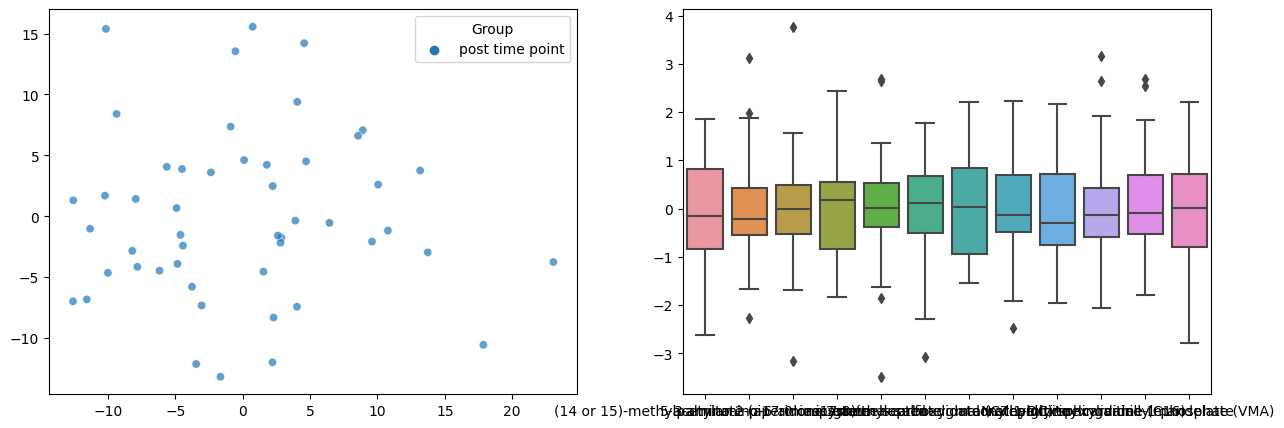

In [7]:
all_data.plot_qc()

## HMDN - bipartite graph

In [32]:
from networkx.algorithms import bipartite
B = nx.Graph()
# Add nodes with the node attribute "bipartite"-
datasets = [sct_data, pmh_data, preterm_data, erbc_data, pkm2_data, azmcn_data]

B.add_nodes_from([i.node_name for i in datasets], bipartite=0)
B.add_nodes_from(sum([i.DA_metabolites for i in datasets], []), bipartite=1)
# Add edges only between nodes of opposite node sets
B.add_edges_from(sum([i.connection for i in datasets], []))

In [33]:
bottom_nodes, top_nodes = bipartite.sets(B)

In [34]:
nx.is_connected(B)

True

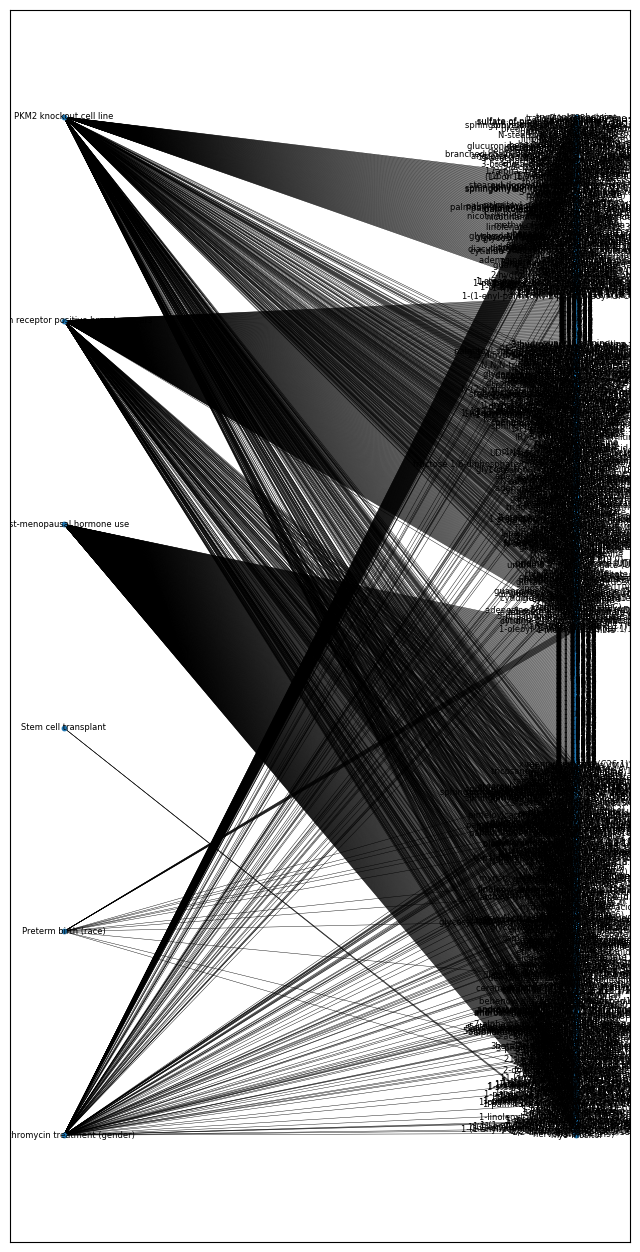

In [27]:
plt.figure(3,figsize=(8,16)) 
nx.draw_networkx(
    B,
    pos = nx.drawing.layout.bipartite_layout(B, bottom_nodes),
    font_size=6,
    width = 0.3,
    with_labels=True,
    node_size=10,
    ) # Or whatever other display options you like

plt.show()

In [35]:
bottom_nodes

{' ER+ BC (treatment response)',
 'Azythromycin treatment (gender)',
 'PKM2 knockout cell line (GT)',
 'Post-menopausal hormone use',
 'Preterm birth (race)',
 'Stem cell transplant (donor/recipient)'}

Stem cell transplant (donor/recipient)
Post-menopausal hormone use
Preterm birth (race)
 ER+ BC (treatment response)
PKM2 knockout cell line (GT)
Azythromycin treatment (gender)


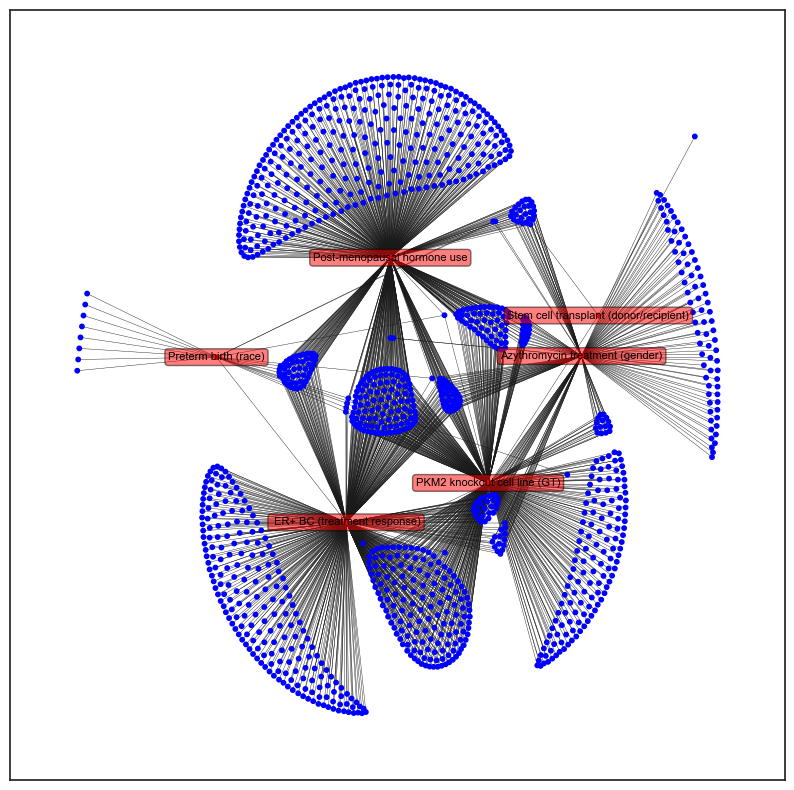

In [52]:

# force directed layout
pos = nx.drawing.layout.kamada_kawai_layout(B)
color_map = []
labels = {}
for node in B:
    if node in bottom_nodes:
        print(node)
        color_map.append('red')
        labels[node] = node
    else: 
        color_map.append('blue')    
        # labels[node] = ''  

plt.figure(3,figsize=(10 ,10)) 
nx.draw_networkx(
    B,
    pos = pos,
    font_size=6,
    width = 0.3,
    with_labels=False,
    node_size=10,
    node_color=color_map
    ) # Or whatever other display options you like
nx.draw_networkx_labels(B, pos, labels,
                        bbox = dict(facecolor = "red", alpha=0.5, edgecolor='black', boxstyle='round,pad=0.3'),
                        font_size=8,
                        font_color='black')

plt.show()

In [86]:
# export gml for cytoscape
nx.write_graphml_lxml(B, "metabolon_HMDN.graphml")

### HDN - disease-disease network
- Nodes are connected if they share common metabolites
- The weight of the edge is the number of common metabolites

In [43]:
biadj_mat = nx.bipartite.biadjacency_matrix(B, row_order=bottom_nodes, column_order=top_nodes).toarray()

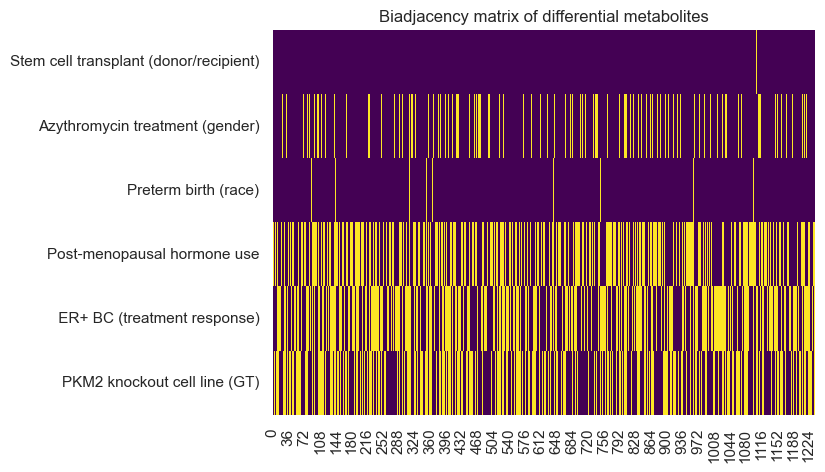

In [44]:
sns.set(style='whitegrid')
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(biadj_mat, cmap='viridis', cbar=False)
ax.set_yticklabels(bottom_nodes, rotation=0)
ax.set_title('Biadjacency matrix of differential metabolites')
plt.show()

In [46]:
# create adjacency matrix based on the number of shared metabolites
# this can be done by multiplying the biadjacency matrix by its transpose
adj_mat = pd.DataFrame(biadj_mat @ biadj_mat.T, index=list(bottom_nodes), columns=list(bottom_nodes))


In [47]:
adj_mat

,Stem cell transplant (donor/recipient),Azythromycin treatment (gender),Preterm birth (race),Post-menopausal hormone use,ER+ BC (treatment response),PKM2 knockout cell line (GT)
Stem cell transplant (donor/recipient),3,1,0,1,1,1
Azythromycin treatment (gender),1,213,3,84,77,95
Preterm birth (race),0,3,22,12,10,8
Post-menopausal hormone use,1,84,12,612,198,220
ER+ BC (treatment response),1,77,10,198,596,321
PKM2 knockout cell line (GT),1,95,8,220,321,539


In [82]:
len(set(sct_data.DA_metabolites) & set(pmh_data.DA_metabolites))

84

c:\Users\cw2019\.conda\envs\py10\lib\site-packages\seaborn\matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


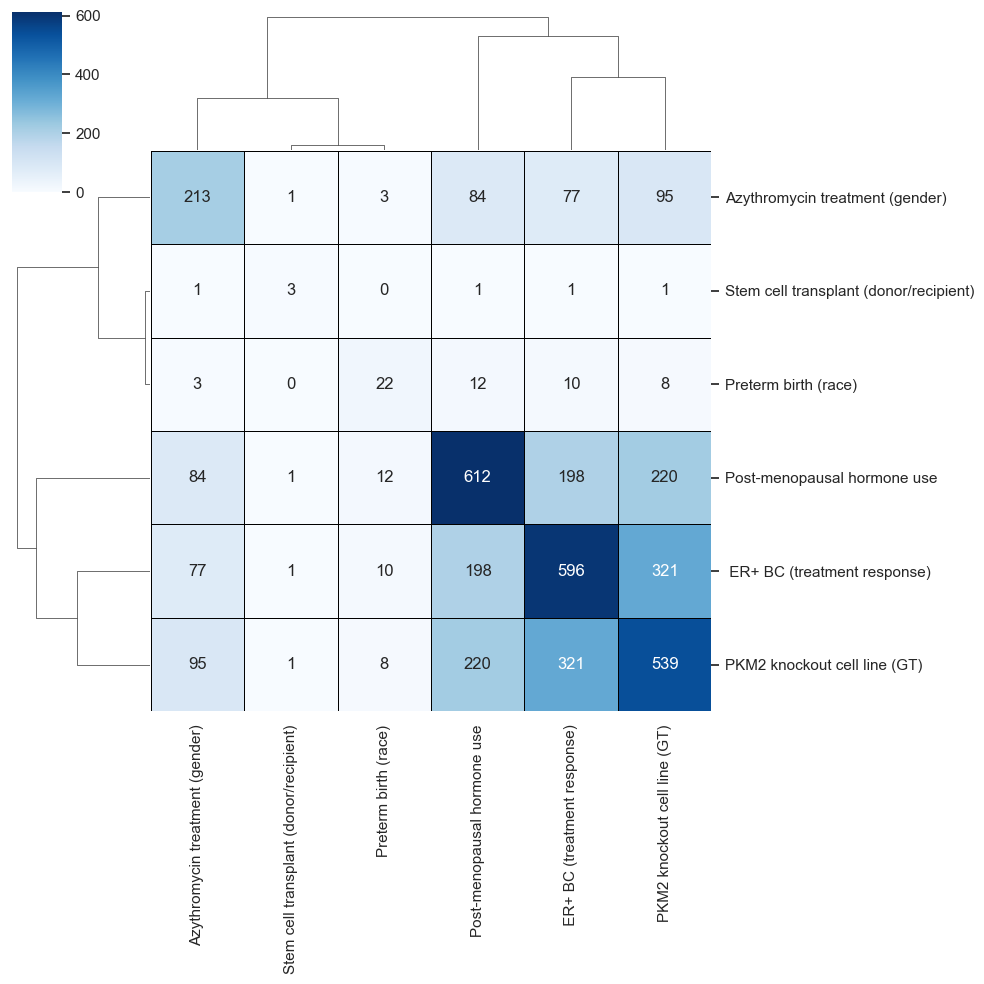

In [48]:
# fig, ax = plt.subplots(figsize=(7, 5))
sns.set(style='white')
sns.clustermap(
    adj_mat, 
    cmap='Blues', 
    square=True, 
    annot=True, 
    # cbar=False, 
    fmt='d', 
    linewidths=0.5, 
    linecolor='black' )
# ax.set_yticklabels(bottom_nodes, rotation=0)
# ax.set_xticklabels(bottom_nodes, rotation=90)
ax.set_title('Similarity matrix of differential metabolites')
# plt.tight_layout()
plt.show()


In [49]:
# make pandas edgelist
edgelist = adj_mat.stack().reset_index()
edgelist.columns = ['source', 'target', 'weight']



In [104]:
edgelist

,source,target,weight
0,Stem cell transplant,Stem cell transplant,213
1,Stem cell transplant,estrogen receptor positive breast cancers,77
2,Stem cell transplant,Post-menopausal hormone use,84
3,Stem cell transplant,Preterm birth,3
4,estrogen receptor positive breast cancers,Stem cell transplant,77
5,estrogen receptor positive breast cancers,estrogen receptor positive breast cancers,596
6,estrogen receptor positive breast cancers,Post-menopausal hormone use,198
7,estrogen receptor positive breast cancers,Preterm birth,10
8,Post-menopausal hormone use,Stem cell transplant,84
9,Post-menopausal hormone use,estrogen receptor positive breast cancers,198


In [50]:
hdn_graph = nx.from_pandas_edgelist(edgelist, edge_attr='weight')
hdn_graph.remove_edges_from(nx.selfloop_edges(hdn_graph))

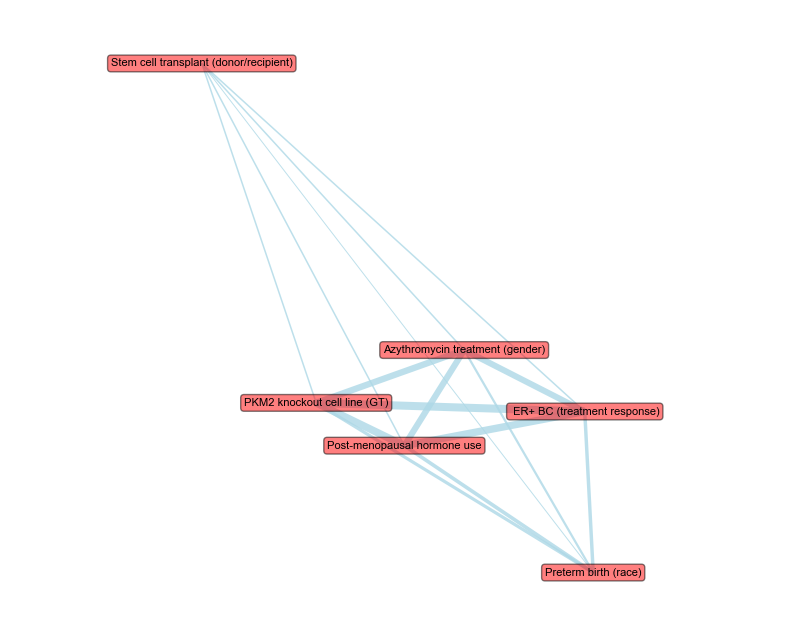

In [56]:

widths = nx.get_edge_attributes(hdn_graph, 'weight')
nodelist = hdn_graph.nodes()

plt.figure(figsize=(10,8))

pos = nx.spring_layout(hdn_graph)
nx.draw_networkx_nodes(hdn_graph,pos,
                       nodelist=nodelist,
                       node_size=0,
                       node_color='white',
                       alpha=0.7)
nx.draw_networkx_edges(hdn_graph,pos,
                       edgelist = widths.keys(),
                       width=[np.log(i+2) for i in list(widths.values())],
                       edge_color='lightblue',
                       alpha=0.8)
nx.draw_networkx_labels(hdn_graph, pos=pos,
                        labels=dict(zip(nodelist,nodelist)),
                        bbox = dict(facecolor = "red", alpha=0.5, edgecolor='black', boxstyle='round,pad=0.3'),
                        font_size=8,
                        font_color='black')
plt.box(False)
plt.margins(x=0.4)
plt.savefig('../Figures/metabolon_HDN.png', dpi=300, bbox_inches='tight')
plt.show()

## DMN - disease-metabolite network
- Nodes (metabolites) are connected if they share the same disease

In [57]:
# create adjacency matrix based on the number of shared metabolites
# this can be done by multiplying the biadjacency matrix by its transpose
adj_mat_dmn = pd.DataFrame(biadj_mat.T @ biadj_mat, index=list(top_nodes), columns=list(top_nodes))


In [53]:
'behenoyl dihydrosphingomyelin (d18:0/22:0)*' in pmh_data.DA_metabolites

True

In [58]:
adj_mat_dmn

,oxindolylalanine,pyridoxine (Vitamin B6),X - 07765,oleoyl CoA,2'-deoxycytidine,acetyl CoA,X - 24849,N-stearoyl-sphinganine (d18:0/18:0)*,S-lactoylglutathione,2-hydroxy-3-methylvalerate,...,5-aminovalerate,serotonin,hexadecanedioate (C16-DC),1-stearoyl-2-linoleoyl-GPC (18:0/18:2)*,sphingosine 1-phosphate,3-hydroxydecanoylcarnitine,X - 21821,3-ketosphinganine,laurylcarnitine (C12),glutarylcarnitine (C5-DC)
oxindolylalanine,1,0,0,0,0,1,0,0,0,0,...,0,0,1,1,1,1,0,0,1,0
pyridoxine (Vitamin B6),0,1,0,1,1,0,0,0,1,1,...,1,1,0,1,0,0,0,1,1,0
X - 07765,0,0,1,0,0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,1,1
oleoyl CoA,0,1,0,1,1,0,0,0,1,1,...,1,1,0,1,0,0,0,1,1,0
2'-deoxycytidine,0,1,0,1,1,0,0,0,1,1,...,1,1,0,1,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3-hydroxydecanoylcarnitine,1,0,0,0,0,1,0,0,0,0,...,0,0,1,1,1,1,0,0,1,0
X - 21821,0,0,1,0,0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,1,1
3-ketosphinganine,0,1,0,1,1,0,0,0,1,1,...,1,1,0,1,0,0,0,1,1,0
laurylcarnitine (C12),1,1,1,1,1,1,1,0,1,1,...,1,1,1,3,1,1,1,1,3,1


In [59]:
# make pandas edgelist
edgelist_dmn = adj_mat_dmn.stack().reset_index()
edgelist_dmn.columns = ['source', 'target', 'weight']
edgelist_dmn = edgelist_dmn[edgelist_dmn['weight'] > 2]

In [154]:
edgelist_dmn

,source,target,weight
13640,N-palmitoyl-heptadecasphingosine (d17:1/16:0)*,N-palmitoyl-heptadecasphingosine (d17:1/16:0)*,3
13656,N-palmitoyl-heptadecasphingosine (d17:1/16:0)*,valylleucine,3
13680,N-palmitoyl-heptadecasphingosine (d17:1/16:0)*,ribitol,3
13684,N-palmitoyl-heptadecasphingosine (d17:1/16:0)*,betaine,3
13688,N-palmitoyl-heptadecasphingosine (d17:1/16:0)*,glycerophosphorylcholine (GPC),3
...,...,...,...
1533861,laurylcarnitine (C12),1-palmitoyl-2-oleoyl-GPE (16:0/18:1),3
1533866,laurylcarnitine (C12),1-palmitoleoyl-GPC (16:1)*,3
1533869,laurylcarnitine (C12),linolenoylcarnitine (C18:3)*,3
1533875,laurylcarnitine (C12),1-stearoyl-2-linoleoyl-GPC (18:0/18:2)*,3


In [60]:
dmn_graph = nx.from_pandas_edgelist(edgelist_dmn, edge_attr='weight')
dmn_graph.remove_edges_from(nx.selfloop_edges(dmn_graph))
nx.set_node_attributes(dmn_graph, dict(dmn_graph.degree()), 'degree')

In [61]:
nx.density(dmn_graph)

0.6290786714139395

<AxesSubplot:ylabel='Count'>

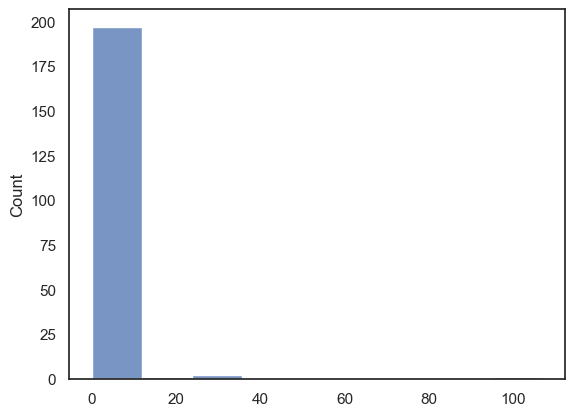

In [62]:
sns.histplot(nx.degree_histogram(dmn_graph))

In [63]:
print(dmn_graph.number_of_nodes())
print(dmn_graph.number_of_edges())

203
12898


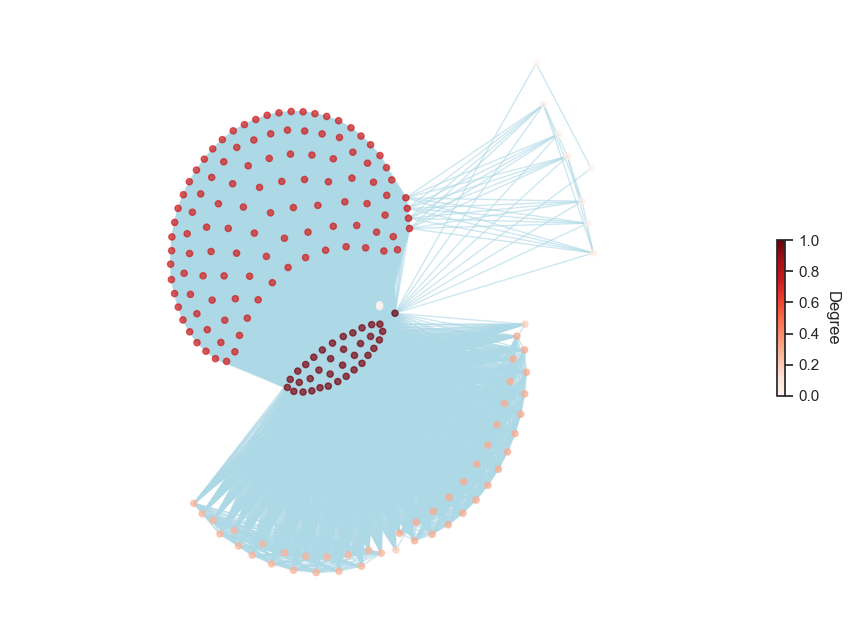

In [64]:

widths = nx.get_edge_attributes(dmn_graph, 'weight')
nodelist = dmn_graph.nodes()

plt.figure(figsize=(10,8))

pos = nx.kamada_kawai_layout(dmn_graph)
nds = nx.draw_networkx_nodes(dmn_graph,pos,
                       nodelist=nodelist,
                       node_size=20,
                       node_color=list(nx.get_node_attributes(dmn_graph, 'degree').values()),
                       cmap='Reds',
                       alpha=0.7)
nx.draw_networkx_edges(dmn_graph,pos,
                       edgelist = widths.keys(),
                    #    width=[i/10 for i in list(widths.values())],
                       edge_color='lightblue',
                       alpha=0.6)
# nx.draw_networkx_labels(dmn_graph, pos=pos,
#                         labels=dict(zip(nodelist,nodelist)),
#                         # bbox = dict(facecolor = "red", alpha=0.5, edgecolor='black', boxstyle='round,pad=0.3'),
#                         font_size=8, 
#                         font_color='black')
plt.box(False)
plt.margins(x=0.3)

cmap = plt.cm.Reds

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = plt.colorbar(sm, orientation='vertical', fraction=0.01, pad=0.03)
cbar.ax.set_ylabel('Degree', rotation=-90, va="bottom")
# plt.savefig('../Figures/metabolon_HDN.png', dpi=300, bbox_inches='tight')
plt.show()

## Metabolite-metabolite correlation network
- Spearman correlation between metabolites per dataset
- Average correlation across datasets

In [65]:
def met_corr(datasets):

    # filter by same columns
    common_cols = set.intersection(*[set(d.processed_data.columns) for d in datasets])
    dsets_filt = [d.processed_data.loc[:, common_cols] for d in datasets]

    # calculate spearman correlation
    corrs = [d.iloc[:, :-1].corr(method='spearman').abs() for d in dsets_filt]

    # average correlation
    avg_corr = sum(corrs) / len(corrs)

    return avg_corr
# filter for same columns



In [184]:
avg_corr_mets = met_corr(datasets)

C:\Users\cw2019\AppData\Local\Temp\ipykernel_33052\284953872.py:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dsets_filt = [d.processed_data.loc[:, common_cols] for d in datasets]
C:\Users\cw2019\AppData\Local\Temp\ipykernel_33052\284953872.py:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dsets_filt = [d.processed_data.loc[:, common_cols] for d in datasets]
C:\Users\cw2019\AppData\Local\Temp\ipykernel_33052\284953872.py:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dsets_filt = [d.processed_data.loc[:, common_cols] for d in datasets]
C:\Users\cw2019\AppData\Local\Temp\ipykernel_33052\284953872.py:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  dsets_filt = [d.processed_data.loc[:, common_cols] for d in da

In [67]:
avg_corr_mets

,oleoylcarnitine (C18:1),histidine,N-palmitoyl-sphinganine (d18:0/16:0),isobutyrylcarnitine (C4),leucine,N-acetylleucine,N-acetylarginine,acetylcarnitine (C2),N-acetylvaline,gamma-glutamylglutamine,...,uridine,"sphingomyelin (d18:1/14:0, d16:1/16:0)*",N-acetylphenylalanine,alanine,sphinganine,behenoyl sphingomyelin (d18:1/22:0)*,homostachydrine*,laurylcarnitine (C12),succinylcarnitine (C4-DC),octanoylcarnitine (C8)
oleoylcarnitine (C18:1),1.000000,0.404410,0.457758,0.240078,0.286635,0.209572,0.253528,0.441779,0.341074,0.325428,...,0.384415,0.359954,0.257971,0.283147,0.481886,0.349665,0.300151,0.597370,0.246676,0.569477
histidine,0.404410,1.000000,0.347456,0.349508,0.494410,0.232400,0.296561,0.413128,0.225681,0.400662,...,0.221697,0.345302,0.213177,0.409402,0.226274,0.352331,0.375873,0.464013,0.269924,0.451013
N-palmitoyl-sphinganine (d18:0/16:0),0.457758,0.347456,1.000000,0.300678,0.366955,0.374006,0.234517,0.341515,0.338489,0.305024,...,0.351250,0.532268,0.381818,0.368740,0.485597,0.493991,0.345723,0.387425,0.266171,0.294720
isobutyrylcarnitine (C4),0.240078,0.349508,0.300678,1.000000,0.422274,0.380599,0.366734,0.429746,0.269073,0.247280,...,0.282767,0.266135,0.198474,0.338357,0.164787,0.297230,0.367538,0.312354,0.310047,0.242310
leucine,0.286635,0.494410,0.366955,0.422274,1.000000,0.479329,0.227976,0.332704,0.222035,0.244041,...,0.310804,0.356292,0.288693,0.489452,0.292605,0.333293,0.298006,0.364329,0.252104,0.274620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
behenoyl sphingomyelin (d18:1/22:0)*,0.349665,0.352331,0.493991,0.297230,0.333293,0.266113,0.253986,0.336262,0.239034,0.324642,...,0.283276,0.499443,0.199042,0.322377,0.273285,1.000000,0.359393,0.385676,0.220724,0.307753
homostachydrine*,0.300151,0.375873,0.345723,0.367538,0.298006,0.286018,0.278666,0.347876,0.245778,0.317944,...,0.272699,0.383272,0.183920,0.298951,0.134564,0.359393,1.000000,0.314428,0.231252,0.245096
laurylcarnitine (C12),0.597370,0.464013,0.387425,0.312354,0.364329,0.226258,0.292079,0.611308,0.272893,0.247738,...,0.387867,0.386608,0.129453,0.294722,0.289386,0.385676,0.314428,1.000000,0.222651,0.718654
succinylcarnitine (C4-DC),0.246676,0.269924,0.266171,0.310047,0.252104,0.356618,0.386939,0.310562,0.416837,0.225806,...,0.288168,0.225490,0.301282,0.260250,0.190202,0.220724,0.231252,0.222651,1.000000,0.381653


c:\Users\cw2019\.conda\envs\py10\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


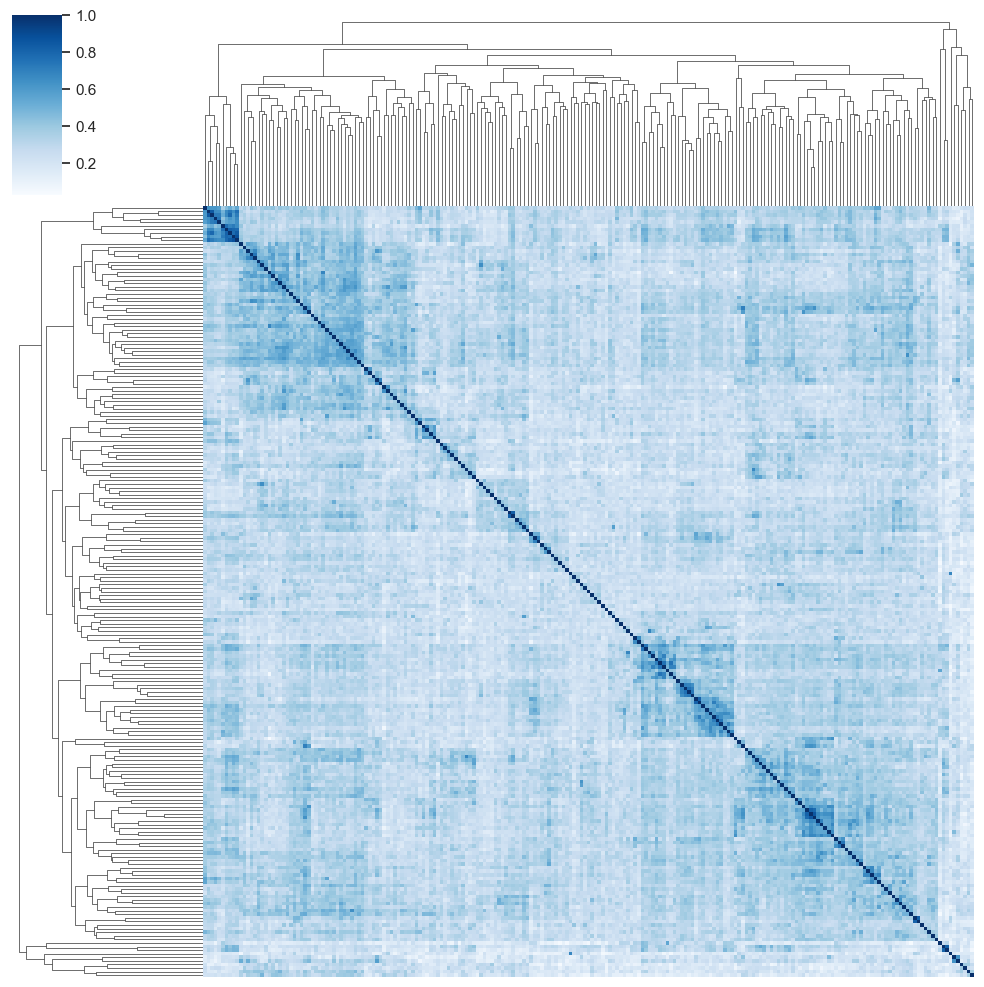

In [70]:
sns.clustermap(
    avg_corr_mets, 
    cmap='Blues', 
    square=True, 
    yticklabels=False,
    xticklabels=False,
    metric='euclidean',
    
    linecolor='black' )

In [71]:
# network 
edgelist_corr = avg_corr_mets.stack().reset_index()
edgelist_corr.columns = ['source', 'target', 'weight']

# filter edges based on significance

edgelist_corr = edgelist_corr[edgelist_corr['weight'] > 0.6]

corr_graph = nx.from_pandas_edgelist(edgelist_corr, edge_attr='weight')
corr_graph.remove_edges_from(nx.selfloop_edges(corr_graph))


In [183]:
azmcn_data.compound_mappers

,0,1,2,3,4,5,6
3,(12 or 13)-methylmyristate (a15:0 or i15:0),Method 3,151014,2485-71-4,NaN,NaN,19291488
4,(14 or 15)-methylpalmitate (a17:0 or i17:0),Method 3,NaN,NaN,NaN,NaN,54960256
5,(16 or 17)-methylstearate (a19:0 or i19:0),Method 3,3083779,2724-59-6,NaN,HMDB37397,2618117
6,(2 or 3)-decenoate (10:1n7 or n8),Method 3,NaN,NaN,NaN,NaN,307046.4063
7,"(2,4 or 2,5)-dimethylphenol sulfate",Method 3,NaN,NaN,NaN,NaN,76865.1563
...,...,...,...,...,...,...,...
1084,xanthosine,Method 3,64959,146-80-5,C01762,HMDB00299,NaN
1085,xanthurenate,Method 3,5699,59-007,C02470,HMDB00881,37024.1836
1086,ximenoylcarnitine (C26:1)*,Method 2,NaN,NaN,NaN,NaN,2056665.125
1087,xylose,Method 4,135191,609-06-3,C00181,HMDB00098,3955594.25


## Chemical class mapping using RAMP API

In [191]:
# get all hmdb for compound class
all_names = sct_data.compound_mappers.loc[:, 0].tolist() + pmh_data.compound_mappers.loc[:, 0].tolist() + preterm_data.compound_mappers.loc[:, 0].tolist() + erbc_data.compound_mappers.loc[:, 0].tolist() + pkm2_data.compound_mappers.loc[:, 0].tolist() +azmcn_data.compound_mappers.loc[:, 0].tolist()
all_hmdb = sct_data.compound_mappers.loc[:, 6].tolist() + pmh_data.compound_mappers.loc[:, 6].tolist() + preterm_data.compound_mappers.loc[:, 5].tolist() + erbc_data.compound_mappers.loc[:, 5].tolist() + pkm2_data.compound_mappers.loc[:, 5].tolist() +azmcn_data.compound_mappers.loc[:, 5].tolist()

In [201]:
all_dict = dict(zip(all_hmdb, all_names))

In [197]:
all_chem_class = get_class_info(all_hmdb)

{'HMDB08138': 'hmdb:HMDB08138', 'HMDB09093': 'hmdb:HMDB09093', 'HMDB00564': 'hmdb:HMDB00564', 'HMDB02123': 'hmdb:HMDB02123', 'HMDB01857': 'hmdb:HMDB01857', 'HMDB02712': 'hmdb:HMDB02712', 'HMDB11103': 'hmdb:HMDB11103', 'HMDB11220': 'hmdb:HMDB11220', 'HMDB11352': 'hmdb:HMDB11352', 'HMDB11211': 'hmdb:HMDB11211', 'HMDB11343': 'hmdb:HMDB11343', 'HMDB11342': 'hmdb:HMDB11342', 'HMDB11207': 'hmdb:HMDB11207', 'HMDB11206': 'hmdb:HMDB11206', 'HMDB10407': 'hmdb:HMDB10407', 'HMDB05779': 'hmdb:HMDB05779', 'HMDB11376': 'hmdb:HMDB11376', 'HMDB11375': 'hmdb:HMDB11375', 'HMDB10395': 'hmdb:HMDB10395', 'HMDB11517': 'hmdb:HMDB11517', 'HMDB61690': 'hmdb:HMDB61690', 'HMDB11549': 'hmdb:HMDB11549', 'HMDB11587': 'hmdb:HMDB11587', 'HMDB10405': 'hmdb:HMDB10405', 'HMDB10388': 'hmdb:HMDB10388', 'HMDB11569': 'hmdb:HMDB11569', 'HMDB08147': 'hmdb:HMDB08147', 'HMDB08141': 'hmdb:HMDB08141', 'HMDB07856': 'hmdb:HMDB07856', 'HMDB10386': 'hmdb:HMDB10386', 'HMDB11507': 'hmdb:HMDB11507', 'HMDB00001': 'hmdb:HMDB00001', 'HMDB02

c:\Users\cw2019\.conda\envs\py10\lib\site-packages\urllib3\connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host 'rampdb.nih.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [203]:
all_chem_class

,sourceId,common_names,class_level_name,class_name,source,directIdClassHits,Original_HMDB,Original_name
0,hmdb:HMDB0000001,1-Methylhistidine,ClassyFire_class,Carboxylic acids and derivatives,hmdb,2,HMDB0000001,1-methylhistidine
1,hmdb:HMDB0000001,1-Methylhistidine,ClassyFire_sub_class,"Amino acids, peptides, and analogues",hmdb,2,HMDB0000001,1-methylhistidine
2,hmdb:HMDB0000001,1-Methylhistidine,ClassyFire_super_class,Organic acids and derivatives,hmdb,2,HMDB0000001,1-methylhistidine
3,hmdb:HMDB00001,1-Methylhistidine,ClassyFire_class,Carboxylic acids and derivatives,hmdb,2,HMDB00001,1-methylhistidine
4,hmdb:HMDB00001,1-Methylhistidine,ClassyFire_sub_class,"Amino acids, peptides, and analogues",hmdb,2,HMDB00001,1-methylhistidine
...,...,...,...,...,...,...,...,...
6977,hmdb:HMDB06547,"C18:4n-3,6,9,12; Stearidonic acid",ClassyFire_sub_class,Lineolic acids and derivatives,hmdb,2,HMDB06547,stearidonate (18:4n3)
6978,hmdb:HMDB06547,"C18:4n-3,6,9,12; Stearidonic acid",ClassyFire_super_class,Lipids and lipid-like molecules,hmdb,2,HMDB06547,stearidonate (18:4n3)
6979,hmdb:HMDB06547,"C18:4n-3,6,9,12; Stearidonic acid",LipidMaps_category,Fatty Acyls [FA],lipidmaps,2,HMDB06547,stearidonate (18:4n3)
6980,hmdb:HMDB06547,"C18:4n-3,6,9,12; Stearidonic acid",LipidMaps_main_class,Fatty Acids and Conjugates [FA01],lipidmaps,2,HMDB06547,stearidonate (18:4n3)


In [210]:
all_chem_class

,sourceId,common_names,class_level_name,class_name,source,directIdClassHits,Original_HMDB,Original_name
0,hmdb:HMDB0000001,1-Methylhistidine,ClassyFire_class,Carboxylic acids and derivatives,hmdb,2,HMDB0000001,1-methylhistidine
1,hmdb:HMDB0000001,1-Methylhistidine,ClassyFire_sub_class,"Amino acids, peptides, and analogues",hmdb,2,HMDB0000001,1-methylhistidine
2,hmdb:HMDB0000001,1-Methylhistidine,ClassyFire_super_class,Organic acids and derivatives,hmdb,2,HMDB0000001,1-methylhistidine
3,hmdb:HMDB00001,1-Methylhistidine,ClassyFire_class,Carboxylic acids and derivatives,hmdb,2,HMDB00001,1-methylhistidine
4,hmdb:HMDB00001,1-Methylhistidine,ClassyFire_sub_class,"Amino acids, peptides, and analogues",hmdb,2,HMDB00001,1-methylhistidine
...,...,...,...,...,...,...,...,...
6977,hmdb:HMDB06547,"C18:4n-3,6,9,12; Stearidonic acid",ClassyFire_sub_class,Lineolic acids and derivatives,hmdb,2,HMDB06547,stearidonate (18:4n3)
6978,hmdb:HMDB06547,"C18:4n-3,6,9,12; Stearidonic acid",ClassyFire_super_class,Lipids and lipid-like molecules,hmdb,2,HMDB06547,stearidonate (18:4n3)
6979,hmdb:HMDB06547,"C18:4n-3,6,9,12; Stearidonic acid",LipidMaps_category,Fatty Acyls [FA],lipidmaps,2,HMDB06547,stearidonate (18:4n3)
6980,hmdb:HMDB06547,"C18:4n-3,6,9,12; Stearidonic acid",LipidMaps_main_class,Fatty Acids and Conjugates [FA01],lipidmaps,2,HMDB06547,stearidonate (18:4n3)


In [286]:
all_chem_class = all_chem_class.drop_duplicates(["Original_name", "class_level_name"])

In [288]:
all_chem_class_multi = pd.melt(all_chem_class, id_vars=['Original_name', 'class_level_name'], value_vars=['class_name'])

In [289]:
all_chem_class_multi

,Original_name,class_level_name,variable,value
0,1-methylhistidine,ClassyFire_class,class_name,Carboxylic acids and derivatives
1,1-methylhistidine,ClassyFire_sub_class,class_name,"Amino acids, peptides, and analogues"
2,1-methylhistidine,ClassyFire_super_class,class_name,Organic acids and derivatives
3,3-methylhistidine,ClassyFire_class,class_name,Carboxylic acids and derivatives
4,3-methylhistidine,ClassyFire_sub_class,class_name,"Amino acids, peptides, and analogues"
...,...,...,...,...
4458,stearidonate (18:4n3),ClassyFire_sub_class,class_name,Lineolic acids and derivatives
4459,stearidonate (18:4n3),ClassyFire_super_class,class_name,Lipids and lipid-like molecules
4460,stearidonate (18:4n3),LipidMaps_category,class_name,Fatty Acyls [FA]
4461,stearidonate (18:4n3),LipidMaps_main_class,class_name,Fatty Acids and Conjugates [FA01]


In [344]:
d = all_chem_class.groupby("Original_name")[["class_level_name", 'class_name']] \
      .apply(lambda x: x.set_index("class_level_name").to_dict(orient="index")) \
      .to_dict()

In [347]:
d = {k: {a: b['class_name'] for a, b in v.items()} for k, v in d.items()}

In [155]:
edgelist_corr

,source,target,weight
0,oleoylcarnitine (C18:1),oleoylcarnitine (C18:1),1.000000
16,oleoylcarnitine (C18:1),palmitoleoylcarnitine (C16:1)*,0.879848
46,oleoylcarnitine (C18:1),myristoleoylcarnitine (C14:1)*,0.651619
70,oleoylcarnitine (C18:1),myristoylcarnitine (C14),0.772602
132,oleoylcarnitine (C18:1),stearoylcarnitine (C18),0.721392
...,...,...,...
46026,octanoylcarnitine (C8),palmitoleoylcarnitine (C16:1)*,0.646895
46056,octanoylcarnitine (C8),myristoleoylcarnitine (C14:1)*,0.646729
46109,octanoylcarnitine (C8),hexanoylcarnitine (C6),0.743433
46222,octanoylcarnitine (C8),laurylcarnitine (C12),0.718654


In [349]:
nx.set_node_attributes(corr_graph, d)

In [350]:
corr_graph.nodes['oleoylcarnitine (C18:1)']

{'ClassyFire_class': 'Fatty Acyls',
 'ClassyFire_sub_class': 'Fatty acid esters',
 'ClassyFire_super_class': 'Lipids and lipid-like molecules',
 'LipidMaps_category': 'Fatty Acyls [FA]',
 'LipidMaps_main_class': 'Fatty esters [FA07]',
 'LipidMaps_sub_class': 'Fatty acyl carnitines [FA0707]'}

In [297]:
corr_graph

['Carboxylic acids and derivatives' 'Keto acids and derivatives'
 'Pyridines and derivatives' 'Steroids and steroid derivatives'
 'Imidazopyrimidines' 'Fatty Acyls' 'Purine nucleotides'
 'Purine nucleosides' 'Diazines' 'Organooxygen compounds'
 'Glycerophospholipids' 'Pyrimidine nucleosides'
 'Organonitrogen compounds' 'Phenols' 'Peptidomimetics'
 'Indoles and derivatives' 'Benzene and substituted derivatives'
 'Organic phosphoric acids and derivatives'
 'Organic sulfonic acids and derivatives' 'Pyrimidine nucleotides'
 'Organic carbonic acids and derivatives' 'Prenol lipids'
 'Hydroxy acids and derivatives' 'Azoles' 'Pteridines and derivatives'
 'Nucleoside and nucleotide analogues'
 'Imidazole ribonucleosides and ribonucleotides' 'Phenylpropanoic acids'
 'Cinchona alkaloids' 'Azolidines' 'Lactones' 'Sphingolipids'
 'Non-metal oxoanionic compounds' "(5'->5')-dinucleotides"
 'Flavin nucleotides' 'Benzimidazoles' 'Triphenyl compounds'
 'Thiadiazines' 'Quinolines and derivatives' 'Coumar

ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not Graph with 215 nodes and 136 edges

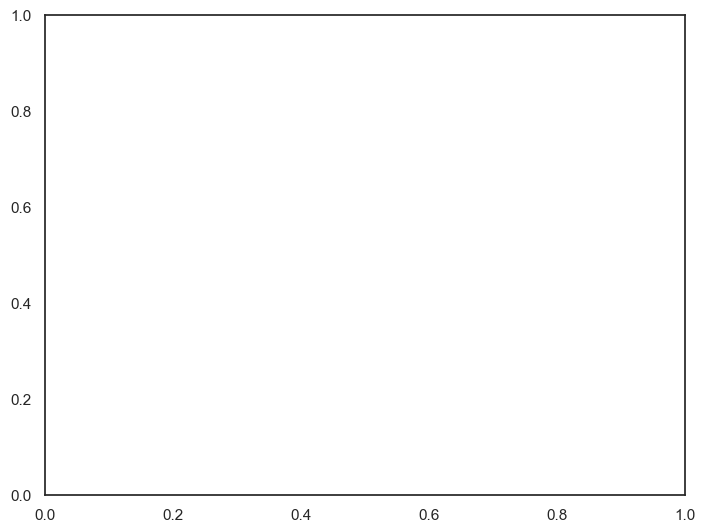

In [356]:
# draw network

# set node colour based on 'ClassyFire class' attribute
get_unique_class = all_chem_class[all_chem_class['class_level_name'] == 'ClassyFire_class']['class_name'].unique()
print(get_unique_class)

nx.draw(corr_graph, with_labels=False, node_size=10, node_color=corr_graph, edge_color='grey', alpha=0.6)

In [351]:
# export gml for cytoscape
nx.write_graphml_lxml(corr_graph, "metabolon_corr.graphml")

- Option to change to HMDB names
- Add chemical class information 